# Más sobre evaluación de modelos y selección de features (tercera parte)

En este tercer notebook vamos a buscar responder la siguiente pregunta: **¿qué datos me conviene incorporar como features de mi modelo?**

Seguimos trabajando con los datos de INTA, así que repetimos el proceso para cargarlos.

In [ ]:
# Como siempre, tratamos de traer todos los paquetes al ppio
from google.colab import drive # Para montar nuestro drive en la consola
import matplotlib.pylab as plt # Para gráficos
import numpy as np # Para manejo de arrays, operaciones matemáticas, etc.
from sklearn.linear_model import LogisticRegression # El método de regresión logística que vamos a usar
import pandas as pd # Para manejo de base de datos

# Traemos los datos
drive.mount('/content/drive') # Montamos nuestra unidad de Google Drive

filename = '/content/drive/My Drive/LaboDatos2021/datosDiariosSanFernandoINTA.xls'

d = pd.read_excel(filename) # Levantamos los datos, en este caso, con el método pd.read_excel
d.head()

Mounted at /content/drive


,Fecha,Temperatura_Abrigo_150cm,Temperatura_Abrigo_150cm_Maxima,Temperatura_Abrigo_150cm_Minima,Temperatura_Intemperie_5cm_Minima,Temperatura_Intemperie_50cm_Minima,Temperatura_Suelo_5cm_Media,Temperatura_Suelo_10cm_Media,Temperatura_Inte_5cm,Temperatura_Intemperie_150cm_Minima,Humedad_Suelo,Precipitacion_Pluviometrica,Precipitacion_Cronologica,Precipitacion_Maxima_30minutos,Heliofania_Efectiva,Heliofania_Relativa,Tesion_Vapor_Media,Humedad_Media,Humedad_Media_8_14_20,Rocio_Medio,Duracion_Follaje_Mojado,Velocidad_Viento_200cm_Media,Direccion_Viento_200cm,Velocidad_Viento_1000cm_Media,Direccion_Viento_1000cm,Velocidad_Viento_Maxima,Presion_Media,Radiacion_Global,Horas_Frio,Unidades_Frio
0,2018-02-08 00:00:00.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,79.0,NaN,NaN,NaN,,NaN,,NaN,NaN,NaN,NaN,NaN
1,2018-02-09 00:00:00.0,23.80764,28.6,20.4,NaN,NaN,NaN,26.21042,NaN,NaN,NaN,11.75,11.75,5.75,NaN,NaN,19.25281,66.0,73.0,16.462780,NaN,1.332639,C,1.665799,C,19.3,NaN,NaN,0.0,-23.904030
2,2018-02-10 00:00:00.0,24.51389,31.7,19.4,NaN,NaN,NaN,26.45972,NaN,NaN,NaN,10.50,0.00,0.00,NaN,NaN,23.28392,72.0,77.0,18.622350,NaN,1.638195,C,2.047743,C,19.0,NaN,NaN,0.0,-23.904030
3,2018-02-11 00:00:00.0,19.50139,24.2,15.1,NaN,NaN,NaN,24.66320,NaN,NaN,NaN,0.00,10.50,4.00,NaN,NaN,14.67725,65.0,67.0,12.071650,NaN,3.247224,E,4.059030,C,20.4,NaN,NaN,0.0,-15.106020
4,2018-02-12 00:00:00.0,16.70625,24.6,9.5,NaN,NaN,NaN,22.63611,NaN,NaN,NaN,0.25,0.00,0.00,NaN,NaN,13.13446,66.0,69.0,9.627476,NaN,1.027778,C,1.284722,C,13.4,NaN,NaN,0.0,-5.394994


Luego, filtramos el dataframe descartando columnas con datos faltantes, seleccionamos un subconjunto de columnas, y las renombramos.

In [ ]:
vars = ['Precipitacion_Pluviometrica','Temperatura_Abrigo_150cm',	'Temperatura_Abrigo_150cm_Maxima',	'Temperatura_Abrigo_150cm_Minima', 'Temperatura_Suelo_10cm_Media', 'Tesion_Vapor_Media',	'Humedad_Media', 'Humedad_Media_8_14_20',	'Rocio_Medio', 'Velocidad_Viento_200cm_Media', 'Velocidad_Viento_1000cm_Media', 'Velocidad_Viento_Maxima', 'Horas_Frio',	'Unidades_Frio']
dictvars = {'Precipitacion_Pluviometrica':'precipitacion','Temperatura_Abrigo_150cm':'var1',	'Temperatura_Abrigo_150cm_Maxima':'var2',	'Temperatura_Abrigo_150cm_Minima':'var3', 'Temperatura_Suelo_10cm_Media':'var4', 'Tesion_Vapor_Media':'var5',	'Humedad_Media':'var6', 'Humedad_Media_8_14_20':'var7',	'Rocio_Medio':'var8', 'Velocidad_Viento_200cm_Media':'var9', 'Velocidad_Viento_1000cm_Media':'var10', 'Velocidad_Viento_Maxima':'var11', 'Horas_Frio':'var12',	'Unidades_Frio':'var13'}

d_filtrado = d[vars].dropna().copy() # Nos quedamos con ciertos campos del data set, para facilitar el trabajo. Y para limitarlo.
                                                  # Notar que primero aplicamos el método .dropna() para eliminar filas que tengan alguna columna con NaN 
                                                  # Ademas, el metodo copy() nos asegura que estemos creando un nuevo dataframe 
d_filtrado.rename(dictvars, axis = 1, inplace = True)
                  

Finalmente, construimos una variable con las etiquetas de los días lluviosos.


In [ ]:
d_filtrado['llueveNollueve'] = 0 # empezamos con una columna llena de 0. 
indice =  d_filtrado['precipitacion'] > 0  # esto me da los valores del indice para los cuales hay precipitacion mayor a 0
d_filtrado.loc[indice, 'llueveNollueve'] = 1 # entonces para esos valores del indice pongo 1, porque en el dia correspondiente, llovio

d_filtrado['llueveNollueve'].value_counts()

0    695
1    324
Name: llueveNollueve, dtype: int64

# Filtros univariados (*select K best*)

En un problema típico tenemos varias variables independientes que podemos usar para entrenar nuestro modelo, o sea, incorporar como features. El problema es que no todos los features son igualmente informativos. Es importante partir de una buena base para esperar que un clasificador tenga un buen desempeño.

Partamos entonces de un clasificador que incorpora varios features para el problema de predecir los días lluviosos y estimemos el AUC haciendo una validación cruzada estratificada con 5 folds.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# Definamos la matriz X
campos = ['var1','var2','var3','var4','var5','var6','var7','var8','var9','var10','var11','var12','var13'] # Lista que contiene las features de interés.
X = d_filtrado[campos].values # En este caso no hace falta reshapear, porque ya tiene la forma que queremos
y = np.array(d_filtrado['llueveNollueve']) # Nuestra etiqueta sigue siende la misma de antes

X_temp = X
for i in np.arange(2,n):
    X_temp = np.concatenate((X_temp,X**i), axis=1)
X = X_temp
 
skf = StratifiedKFold(n_splits=5, shuffle=True) # 5 folds es un número típico si tenemos suficientes datos. Pedimos shuffle=True para que sea al azar la separación en subgrupos
skf.get_n_splits(X, y) # arma los folds a partir de los datos

auc_values = [] # aca es donde van a ir a parar los AUCs de cada fold

for train_index, test_index in skf.split(X, y): # va generando los indices que corresponden a train y test en cada fold
    X_train, X_test = X[train_index], X[test_index] # arma que es dato de entrenamiento y qué es dato de evaluación
    y_train, y_test = y[train_index], y[test_index]     # idem con los targets

    scaler = MinMaxScaler() # escaleo por separado ambos sets
    scaler.fit(X_train) 
    X_train = scaler.transform(X_train)

    scaler = MinMaxScaler() # escaleo por separado ambos sets
    scaler.fit(X_test) 
    X_test = scaler.transform(X_test)

    regLog = LogisticRegression(penalty = 'none', max_iter=10000) # Inicializamos nuevamente el modelo. max_iter es la cantidad de iteraciones maximas del algoritmo de optimizacion de parametros antes de detenerse.
    regLog.fit(X_train, y_train) # Ajustamos el modelo con los datos de entrenamiento

    probas_test = regLog.predict_proba(X_test)  # probabilidades con datos de evaluación
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:,1]) # para plotear curva ROC con datos de entrenamiento
    auc_test = roc_auc_score(y_test, probas_test[:,1]) #  AUC con datos de evaluación
    auc_values.append(auc_test)
print(np.mean(auc_values))


0.7257280713890426


Ahora supongamos que en cada fold decidimos quedarnos con una cantidad reducida de features, por ejemplo, con los K mejores features de acuerdo a un criterio *univariado*. La idea es que en cada fold tenemos en los datos de entrenamiento las etiquetas de la clase de cada ejemplo. Entonces para cada variable por separado podemos obtener una medida de qué tan distinta es dicha variable entre ambas clases. Entonces, vamos a retener las K variables que más diferentes sean entre clases para entrenar cada clasificador. 

Para esto, vamos a usar la función usando la estadística F de ANOVA entre grupos para rankear las mejores features **en cada fold por separado.**

(si hacemos esto antes de dividir en folds, vamos a estar en problemas, porque habremos usado datos de todo el conjunto para determinar el score F y por lo tanto rankear features, pero entonces habremos pasado datos del conjunto de evaluacion al de entrenamiento cuando dividamos en folds)

El AUC promedio es:
0.7299789014941892


Text(0, 0.5, 'Folds')

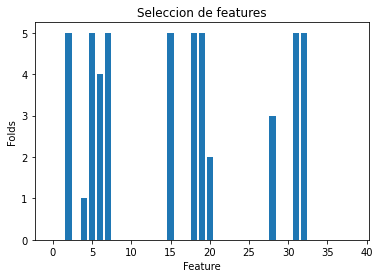

In [ ]:
from sklearn.feature_selection import SelectKBest

# Definamos la matriz X
campos = ['var1','var2','var3','var4','var5','var6','var7','var8','var9','var10','var11','var12','var13'] # Lista que contiene las features de interés.
X = d_filtrado[campos].values # En este caso no hace falta reshapear, porque ya tiene la forma que queremos
y = np.array(d_filtrado['llueveNollueve']) # Nuestra etiqueta sigue siende la misma de antes
X = np.concatenate((X, X**2,X**3), axis=1) # agrego features elevados a potencias 

Kbest = 10 # los mejores K que voy a retener

skf = StratifiedKFold(n_splits=5, shuffle=True) # 5 folds es un número típico si tenemos suficientes datos. Pedimos shuffle=True para que sea al azar la separación en subgrupos
skf.get_n_splits(X, y) # arma los folds a partir de los datos

auc_values_fs =  []  # aca es donde van a ir a parar los indices de los features seleccionados en cada fold
selected_features= np.array([]).reshape(0,X.shape[1]) # aca es donde van a ir a parar los AUCs de cada fold. El reshape es para poder concatenar luego.


for train_index, test_index in skf.split(X, y): # va generando los indices que corresponden a train y test en cada fold
    X_train, X_test = X[train_index], X[test_index] # arma que es dato de entrenamiento y qué es dato de evaluación
    y_train, y_test = y[train_index], y[test_index]     # idem con los targets

    scaler = MinMaxScaler() # escaleo por separado ambos sets
    scaler.fit(X_train) 
    X_train = scaler.transform(X_train)

    scaler = MinMaxScaler() # escaleo por separado ambos sets
    scaler.fit(X_test) 
    X_test = scaler.transform(X_test)

    selector = SelectKBest(k=Kbest) # por defecto, usa el F score de ANOVA y los Kbest features
    selector.fit(X_train, y_train) # encuentro los F scores 
    X_train_fs = selector.transform(X_train) # me quedo con los features mejor rankeados en el set de entrenamiento
    X_test_fs = selector.transform(X_test) # me quedo con los features mejor rankeados en el set de evaluacion
    features = np.array(selector.get_support()).reshape((1,-1)) # esto me pone True si la variable correspondiente fue seleccionada y False sino

    selected_features =  np.concatenate((selected_features,features),axis=0)

    regLog = LogisticRegression(penalty = 'none', max_iter=10000) # Inicializamos nuevamente el modelo. max_iter es la cantidad de iteraciones maximas del algoritmo de optimizacion de parametros antes de detenerse.
    regLog.fit(X_train_fs, y_train) # Ajustamos el modelo con los datos de entrenamiento


    probas_test = regLog.predict_proba(X_test_fs)  # probabilidades con datos de evaluación
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:,1]) # para plotear curva ROC con datos de entrenamiento
    auc_test = roc_auc_score(y_test, probas_test[:,1]) #  AUC con datos de evaluación
    auc_values_fs.append(auc_test)

print('El AUC promedio es:')
print(np.mean(auc_values_fs))


import matplotlib.pyplot as plt

plt.bar(np.arange(0,X.shape[1]),np.sum(selected_features,axis=0))
plt.title('Seleccion de features')
plt.xlabel('Feature')
plt.ylabel('Folds')

Vemos que el AUC promedio obtenido con los K=10 mejores features no es mejor que el AUC obtenido con todos. Esto significa que en este dataset la clasificación no esta basada en un conjunto pequeño de features muy diferentes entre las dos clases, sino que todas parecen contribuir.

Más adelante en la materia vamos a ver otros criterios para seleccionar features, denominados recursivos, los cuales permiten tener en cuenta la interacción entre variables, superando en principio a los filtros univariados (pero requiriendo mucha mayor cantidad de cómputos) 

# Datos categóricos y one-hot encoding

Hasta ahora todos los features con los que trabajamos eran numéricos, variables como temperaturas, humedades, etc. ¿Pero qué pasa si tenemos datos categóricos?

Consideremos por ejemplo la columna 'Direccion_Viento_200cm' en el dataframe original.

In [ ]:
d['Direccion_Viento_200cm'].value_counts()

Estas letras reflejan la dirección del viento. No se trata de variables numéricas ni de ordinales (que podemos representar como 1, 2, 3, etc, en virtud de una relación de orden que tienen). Notar ademas que hay datos faltantes que tendriamos que haber removido (tirar los valores donde no hay nada en la variable).

Tenemos que pasar esta variable a valores numéricos para que sirva de entrada a nuestro modelo. Pero en este caso, no parece haber ningún motivo para que el mapeo dado por:

C=1, E=2, W=3, SE=4

sea preferido por el mapeo

C=3, E=1, W=2, SE=4

o cualquier otra combinación. 

¿Cómo nos sacamos de encima la arbitrareidad del mapeo?

La forma usual es hacer un **one-hot encoding** de los datos. Esto quiere decir, crear una columna nueva para cada valor posible de la variable categorica, y hacer que valga 1 cada fila si tiene el valor que corresponde a la columna. Por ejemplo, creariamos una columna para la variable "C" y los dias en los cuales la direccion del viento tiene valor "C" tendrian un 1 en esa columna, y 0 en otro caso. 

Veamos como se hace en scikit-learn.



In [ ]:
from sklearn.preprocessing import OneHotEncoder

indice = np.logical_not(d['Direccion_Viento_200cm']=='  ') # primero buscamos los valores donde no esta vacio ('  ')

d_filt = d[indice] # nos quedamos con esos valores
print(d_filt['Direccion_Viento_200cm'].value_counts()) # corroboramos que '  ' se haya ido

encoder = OneHotEncoder(sparse=False) # armamos el encoder. sparse=False nos devuelve una matriz comun a la que estamos acostumbrados (en vez de esparsa)
direccion = np.array(d_filt['Direccion_Viento_200cm']).reshape(-1, 1) # aca pasamos a un vector la serie de pandas, como es usual
encoder.fit(direccion) # fiteo
print(encoder.categories_) # estas son las columnas binarias del nuevo encoding
direccion_hot = encoder.transform(direccion) # obtenemos la mariz binaria
print(direccion_hot)



C     886
E     166
W      49
SE     34
Name: Direccion_Viento_200cm, dtype: int64
[array(['C ', 'E ', 'SE', 'W '], dtype=object)]
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


# Para llevarse de este notebook

*   Vimos que podemos trabajar con un subconjunto de los features en cada uno de los folds. Seleccionamos los mejores K features de acuerdo a un cierto criterio (score F de ANOVA) 

```
    selector = SelectKBest(k=Kbest)
    selector.fit(X_train, y_train)
    X_train_fs = selector.transform(X_train) 
    X_test_fs = selector.transform(X_test) 
```


*   Vimos tambien que podemos trabajar con features categoricos haciendo un one-hot encoding, que crea una columna nueva binaria para cada una de los valores de mi variable categorica:


```
encoder = OneHotEncoder(sparse=False) 
direccion = np.array(d_filt['Direccion_Viento_200cm']).reshape(-1, 1) 
encoder.fit(direccion) 
direccion_hot = encoder.transform(direccion)
```







# Preguntas extra

*   ¿Se te ocurre una forma en la que podrias seleccionar un subconjunto de features que mejore la performance del clasificador teniendo en cuenta interacciones entre features, pero sin explorar sistematicamente todos los subconjuntos posibles, lo cual casi siempre es imposible computacionalmente?
*   Construir un clasificador que tenga en cuenta la direccion del viento (usando one-hot encoding) a ver como impacta eso en el AUC

